In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch.nn as nn
import torch.optim as optim
import os

import torchvision.models as models

if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device("cpu")
    
model = models.resnet50(pretrained=True).to(device)
freeze_layers(model, 148)

model.fc = nn.Linear(in_features=2048, out_features=8).to(device)
optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss()

In [58]:
def freeze_layers(model, cutoff):
    count = 0
    for param in model.parameters():
        count += 1
        if count < cutoff:
            param.requires_grad = False
        else:
            param.requires_grad = True

def view_params(model):
    for param in model.parameters():
        print (param.shape, param.requires_grad)

def calculate_accuracy(fx, y):
    preds = fx.max(1, keepdim=True)[1]
    correct = preds.eq(y.view_as(preds)).sum()
    print (correct)
    acc = correct.float()/preds.shape[0]
    return acc

def train(model, device, iterator, optimizer, criterion):
    epoch_loss = 0
    epoch_acc = 0
    
    model.train()
    for (x, y) in iterator:
        x = x.to(device)
        y = y.to(device)
        
        optimizer.zero_grad() 
        fx = model(x)
        loss = criterion(fx, y)
        acc = calculate_accuracy(fx, y)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

def evaluate(model, device, iterator, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.eval()
    
    with torch.no_grad():
        for (x, y) in iterator:

            x = x.to(device)
            y = y.to(device)
            
            for i in zip(x, y):
                xarr = x.detach().cpu().numpy()
                yarr = y.detach().cpu().numpy()
                print(type(xarr[i,:,:,:]))#, xarr[i].shape)
                print(type(yarr), yarr.shape, type(yarr[i]))#, yarr[i].shape)
                img = Image.fromarray(arr, 'RGB')
                img.show()
                print(y, "\n\n-------------------\n")

            fx = model(x)
            loss = criterion(fx, y)
            acc = calculate_accuracy(fx, y)

            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [ ]:
train_transforms = transforms.Compose([
                           transforms.RandomHorizontalFlip(),
                           transforms.RandomRotation(10),
                           transforms.RandomCrop((224, 224), pad_if_needed=True),
                           transforms.ToTensor(),
                           transforms.Normalize((0.485, 0.456, 0.406),(0.229, 0.224, 0.225))
                       ])

BATCH_SIZE = 64

train_data = datasets.ImageFolder('train', train_transforms)
print(f'Number of training examples: {len(train_data)}')
train_iterator = torch.utils.data.DataLoader(train_data, shuffle=True, batch_size=BATCH_SIZE)
#valid_iterator = torch.utils.data.DataLoader(valid_data, batch_size=BATCH_SIZE)

In [0]:
EPOCHS = 100
SAVE_DIR = 'models'
MODEL_SAVE_PATH = os.path.join(SAVE_DIR, 'resnet18-dogs-vs-cats.pt')

best_valid_loss = float('inf')

if not os.path.isdir(f'{SAVE_DIR}'):
    os.makedirs(f'{SAVE_DIR}')

for epoch in range(EPOCHS):
    train_loss, train_acc = train(model, device, train_iterator, optimizer, criterion)
#     valid_loss, valid_acc = evaluate(model, device, valid_iterator, criterion)
    
#     if valid_loss < best_valid_loss:
#         best_valid_loss = valid_loss
    torch.save(model.state_dict(), MODEL_SAVE_PATH)
    
#     print(f'| Epoch: {epoch+1:02} | Train Loss: {train_loss:.3f} | Train Acc: {train_acc*100:05.2f}% ) #| Val. Loss: {valid_loss:.3f} | Val. Acc: {valid_acc*100:05.2f}% |')
    print(f'| Epoch: {epoch+1:02} | Train Loss: {train_loss:.3f} | Train Acc: {train_acc*100:05.2f}% ')

In [0]:
test_transforms = transforms.Compose([
                           transforms.CenterCrop((224, 224)),
                           transforms.ToTensor(),
                           transforms.Normalize((0.485, 0.456, 0.406),(0.229, 0.224, 0.225))
                       ])

test_data = datasets.ImageFolder('test', test_transforms)
test_iterator = torch.utils.data.DataLoader(test_data, batch_size=BATCH_SIZE)

model.load_state_dict(torch.load(MODEL_SAVE_PATH))

test_loss, test_acc = evaluate(model, device, test_iterator, criterion)

print(f'| Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:05.2f}% |')

tensor(59, device='cuda:0')
tensor(61, device='cuda:0')
tensor(60, device='cuda:0')
tensor(62, device='cuda:0')
tensor(59, device='cuda:0')
tensor(64, device='cuda:0')
tensor(14, device='cuda:0')
| Test Loss: 0.183 | Test Acc: 95.76% |


## Load Model 

In [98]:
PATH = "./dex-1.pt"

import torchvision.models as models
from PIL import Image, ImageDraw
from torch.autograd import Variable

if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device("cpu")

model = models.resnet50(pretrained=True).to(device)

model.fc = nn.Linear(in_features=2048, out_features=8).to(device)
optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss()

model.load_state_dict(torch.load(PATH))#.to(device)

test_transforms = transforms.Compose([
                           transforms.CenterCrop((224, 224)),
                           transforms.ToTensor(),
                           transforms.Normalize((0.485, 0.456, 0.406),(0.229, 0.224, 0.225))
                       ])

test_data = datasets.ImageFolder('test', test_transforms)
test_iterator = torch.utils.data.DataLoader(test_data, batch_size=BATCH_SIZE)


test_loss, test_acc = evaluate(model, device, test_iterator, criterion)

print(f'| Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:05.2f}% |')

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [28]:
img_path = "./clara.jpg"
imsize = 256
loader = transforms.Compose([transforms.Scale(imsize), transforms.ToTensor()])

def predict(model, img_path):
    image = Image.open(image_path)
    image = loader(image).float()
    image = Variable(image, requires_grad=True)
    image = image.unsqueeze(0).to(device)    
    key = torch.argmax(model(image).data[0])

model(image).data[0]

tensor([ 0.1356, -1.7736, -3.7210,  0.5360, -2.3370, -0.0544,  0.5681, -1.0506],
       device='cuda:0')

In [88]:
for (x, y) in test_iterator[0]:

    for i in range(1):
        xarr = x.cpu().numpy()[i,:,:,:].transpose(2,1,0)
        print(type(xarr))
        yarr = y.cpu().numpy()
        print(type(xarr), xarr.shape)#[i,:,:,:]))#, xarr[i].shape)
        print(len(yarr))#, type(yarr[i]))#, yarr[i].shape)
        img = Image.fromarray(xarr, 'RGB')
        img.show()
        print(y, "\n\n-------------------\n")



TypeError: 'DataLoader' object is not subscriptable

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


NameError: name 'classes' is not defined

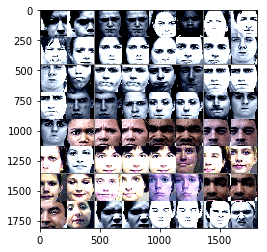

In [97]:
%matplotlib inline  
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

dataiter = iter(test_iterator)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))